## Credit Default Prediction Modelling. 

### Introduction
- In this notebook, we explore a classification problem using XGBoost for a model to predict credit card defaulting based on some data on the user. 
- We'll use BQ opensource data source for the model. 

#### Data Import and EDA

In [2]:
from data_pipeline import load_credit_data
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
import pickle

sns.set_style("darkgrid")

df = load_credit_data()

df.head()


2025-06-04 11:33:02,120 - INFO - Attempting to load data from BigQuery...
2025-06-04 11:33:08,264 - INFO - Data successfully loaded from BigQuery and saved to CSV.


,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month,predicted_default_payment_next_month
id,,,,,,,,,,,,,,,,,,,,,
27502.0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0,...,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1,"[{'tables': {'score': 0.8667634129524231, 'val..."
26879.0,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0,...,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0,"[{'tables': {'score': 0.9351968765258789, 'val..."
18340.0,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0,...,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1,"[{'tables': {'score': 0.8572560548782349, 'val..."
13692.0,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0,...,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0,"[{'tables': {'score': 0.9690881371498108, 'val..."
20405.0,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0,...,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0,"[{'tables': {'score': 0.9349926710128784, 'val..."


In [5]:
df.describe()


,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
count,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,...,2965.000000,2965.000000,2965.000000,2965.000000,2.965000e+03,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000
mean,163369.308600,1.607757,1.849578,1.559865,35.193255,0.005059,-0.122428,-0.141653,-0.185160,-0.225295,...,44089.683305,40956.080607,39773.072513,6348.902867,6.272494e+03,5150.497133,4561.376054,4913.286678,5382.701518,0.214165
std,125030.415472,0.488333,0.778184,0.522317,9.109439,1.114395,1.180784,1.183630,1.178322,1.159003,...,61907.454056,58271.904751,57303.488981,20885.735336,2.887967e+04,14287.079982,13281.499599,16734.340778,17275.953029,0.410311
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-46627.000000,-46627.000000,-73895.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2582.000000,1958.000000,1430.000000,1013.000000,9.900000e+02,477.000000,313.000000,323.000000,173.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19894.000000,18814.000000,18508.000000,2234.000000,2.175000e+03,1994.000000,1600.000000,1646.000000,1615.000000,0.000000
75%,230000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58622.000000,53373.000000,52287.000000,5087.000000,5.000000e+03,4500.000000,4000.000000,4021.000000,4081.000000,0.000000
max,800000.000000,2.000000,6.000000,3.000000,69.000000,8.000000,7.000000,7.000000,8.000000,7.000000,...,488808.000000,441981.000000,436172.000000,493358.000000,1.227082e+06,199209.000000,202076.000000,388071.000000,403500.000000,1.000000


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2965 entries, 27502.0 to 28122.0
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   limit_balance                         2965 non-null   float64
 1   sex                                   2965 non-null   int64  
 2   education_level                       2965 non-null   int64  
 3   marital_status                        2965 non-null   int64  
 4   age                                   2965 non-null   float64
 5   pay_0                                 2965 non-null   float64
 6   pay_2                                 2965 non-null   float64
 7   pay_3                                 2965 non-null   float64
 8   pay_4                                 2965 non-null   float64
 9   pay_5                                 2965 non-null   float64
 10  pay_6                                 2965 non-null   float64
 11  bill_amt_1   

In [23]:
# converting to correct data types
df[["pay_5", "pay_6"]] = df[["pay_5", "pay_6"]].astype("float64")

df[['sex', 'education_level', 'marital_status']] = df[['sex', 'education_level', 'marital_status']].astype("str")

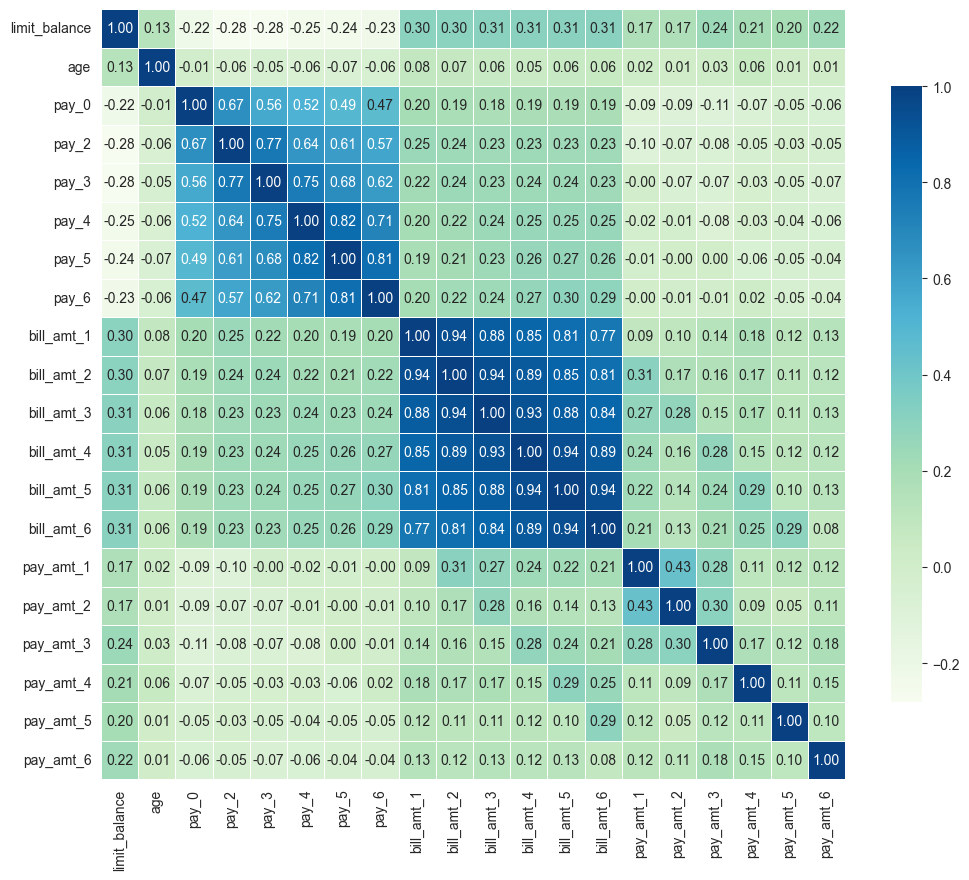

In [34]:
plt.figure(figsize=(12, 10))

sns.heatmap(
    df.drop(columns='default_payment_next_month').corr(numeric_only=True),
    annot=True,
    cmap="GnBu",
    linewidths=0.7,
    linecolor="white",
    fmt=".2f",
    cbar_kws={"shrink": 0.8},
)

plt.grid(False)
# there is a not much risk of multicollinearity in the dataset, as the correlation coefficients are generally <0.95.

In [27]:
# checking for class imbalance in the target variable
# there is class imbalance in the target variable so we will try oversampling

df.default_payment_next_month.value_counts(normalize=True)

default_payment_next_month
0    0.785835
1    0.214165
Name: proportion, dtype: float64

In [28]:
# preparing data to encode categorical features.
# we'll use OneHotEncoder for this purpose since there are no ordinal features in the dataset.

df.drop(columns="predicted_default_payment_next_month").select_dtypes(
    include=["object"]
).nunique()

sex                2
education_level    7
marital_status     4
dtype: int64

#### Data Preprocessing

In [29]:
# Splitting the data into features and target variable

X = df.drop(
    columns=["default_payment_next_month", "predicted_default_payment_next_month"]
)

y = df.default_payment_next_month.astype("int")

In [30]:
# splitting data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Model Traininng and Evaluation

#### (i) Using `RandomOverSampler` to handle class imbalance

Fitting 3 folds for each of 10 candidates, totalling 30 fits
              precision    recall  f1-score   support

  No Default       0.88      0.86      0.87       473
     Default       0.49      0.53      0.51       120

    accuracy                           0.79       593
   macro avg       0.68      0.69      0.69       593
weighted avg       0.80      0.79      0.80       593



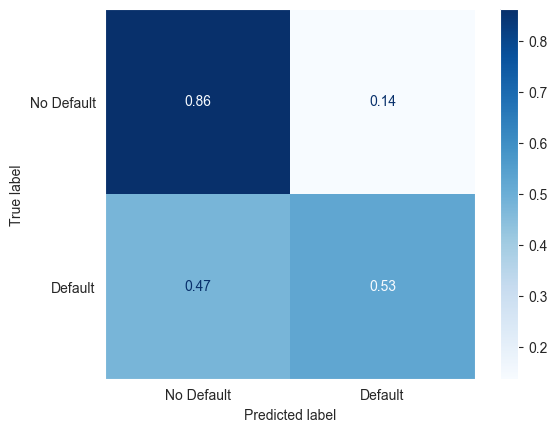

In [31]:
over_sampler = RandomOverSampler(random_state=42)

# possible data leakage**
X_train_resampled, y_train_resampled = over_sampler.fit_resample(X_train, y_train)

xgb_over = make_pipeline(
    OneHotEncoder(handle_unknown="ignore", sparse_output=False),
    XGBClassifier(random_state=42, scale_pos_weight=1),
)

param_grid = {
    "xgbclassifier__n_estimators": [100, 300],
    "xgbclassifier__max_depth": [3, 6, 10],
    "xgbclassifier__learning_rate": [0.01, 0.1],
    "xgbclassifier__subsample": [0.8, 1.0],
    "xgbclassifier__colsample_bytree": [0.8, 1.0],
    "xgbclassifier__gamma": [0, 1],
    "xgbclassifier__reg_alpha": [0, 0.1],
    "xgbclassifier__reg_lambda": [1, 10],
    }

xgb_over_model = RandomizedSearchCV(
    xgb_over, param_grid, scoring="f1", cv=3, verbose=1, n_jobs=-1
)

xgb_over_model.fit(X_train_resampled, y_train_resampled)

with open("models/xgb_over_model.pkl", "wb") as f:
    pickle.dump(xgb_over_model, f)

print(
    classification_report(
        y_test,
        xgb_over_model.predict(X_test),
        target_names=["No Default", "Default"],
    )
)

ConfusionMatrixDisplay.from_estimator(
    xgb_over_model,
    X_test,
    y_test,
    display_labels=["No Default", "Default"],
    cmap="Blues",
    normalize="true",
)

plt.grid(False)

In [32]:
# loading the saved model:

with open("models/xgb_over_model.pkl", "rb") as f:
    loaded_xgb_over_model = pickle.load(f)

loaded_xgb_over_model

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('onehotencoder',
                                              OneHotEncoder(handle_unknown='ignore',
                                                            sparse_output=False)),
                                             ('xgbclassifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,...
                   n_jobs=-1,
                   param_distributions={'xgbclassifier__colsample_bytree': [0.8,
                                                                            1.0],
                                        'xgbclassifier__gamma': [0, 1],
                                        'xgbclassifier__learning_rate': [0.01,
                                                                         0.1],
                                        'xgbclassifier__max_depth': [3, 6, 10],
                                        'xgbclassifier__n_estimators': [100,
                                                                        300],
                                        'xgbclassifier__reg_alpha': [0, 0.1],
                                        'xgbclassifier__reg_lambda': [1, 10],
                                        'xgbclassifier__subsample': [0.8, 1.0]},
                   scoring='f1', verbose=1)

#### (ii) Using `scale_pos_weight` to handle class imbalance

Fitting 3 folds for each of 10 candidates, totalling 30 fits
              precision    recall  f1-score   support

  No Default       0.90      0.64      0.75       473
     Default       0.33      0.71      0.45       120

    accuracy                           0.65       593
   macro avg       0.61      0.67      0.60       593
weighted avg       0.78      0.65      0.69       593



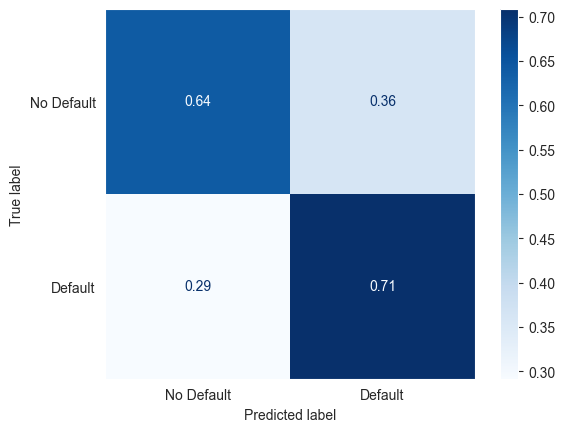

In [33]:
xgb_ = make_pipeline(
    OneHotEncoder(handle_unknown="ignore", sparse_output=False),
    XGBClassifier(scale_pos_weight=78.58 / 21.42, random_state=42),
)

xgb_model = RandomizedSearchCV(xgb_, param_grid, scoring="f1", cv=3, verbose=1, n_jobs=-1)

xgb_model.fit(X_train_resampled, y_train_resampled)

with open("models/xgb_model.pkl", "wb") as f:
    pickle.dump(xgb_over_model, f)

print(
    classification_report(
        y_test,
        xgb_model.predict(X_test),
        target_names=["No Default", "Default"],
    )
)

ConfusionMatrixDisplay.from_estimator(
    xgb_model,
    X_test,
    y_test,
    display_labels=["No Default", "Default"],
    cmap="Blues",
    normalize="true",
)

plt.grid(False)

In [1]:
with open("models/xgb_model.pkl", "rb") as f:
    loaded_xgb_model = pickle.load(f)  

loaded_xgb_model.best_params_

NameError: name 'pickle' is not defined